In [276]:
#Include important files
include("TestBestPlannerHeader.jl")
include("BestLocalPlannerGuts.jl")


selfGradientDescent (generic function with 1 method)

(Float64, Array{Float64, 2}, Array{Int64, 1}, Float64) in module Main at C:\Users\tmurphy10\Documents\ShieldAi\polynomial-path-smoothing\TestBestPlannerHeader.jl:16 overwritten at C:\Users\tmurphy10\Documents\ShieldAi\polynomial-path-smoothing\TestBestPlannerHeader.jl:16.


In [272]:
#Construct the all the containers
tuningI = TuningParams([0;1;0;1;0],    # q_coeff::Vector{Int64}
                       [0.0;0.0;5000.0],    # softConstrWeights::Vector{Float64}
                        0.1,           # numericVelWeight::Float64       
                        1,             # obstacleWeight::Float64    
                        0.1,           # derivativeWeight::Float64     
                        0.02,          # precision::Float64              
                        100,            # iterations::Int64      
                        0.01,          # timeStep::Float64     
                        2.0,           # timeStart::Float64    
                        0.7,           # aggressParam:Float64        
                        0.1,           # timeIncrease::Float64            
                        2.0,           # max_vel::Float64           
                        0.65,          # max_accel::Float64        
                        10.0,          # max_jerk::Float64             
                        10,            # numberOfRandomRestarts::Int64   
                        10,            # timeWeight::Float64    
                        100,           # timeRes::Int64   
                        0.01,          # precisionVel::Float64            
                        0.95,          # percentAcc::Float64               
                        1000,           # accelWeight::Float64        
                        0.05,          # perturbation::Float64
                        0.25,        # posMaxAdd::Float64
                        0.05,         # velMaxAdd::Float64
                        0.05,         # accelMaxAdd::Float64
                        1);          # jerkMaxAdd::Float64
problem = PathProblem( [1.0 0.0 0.0;        # x
                        1.0 0.0 0.0;        # y
                        1.0 0.0 0.0],       # z  #start_config::Array{Float64,2}   
                       [5.0 0.0 0.0;                # x
                        5.0 0.0 0.0;                # y
                        7.0 0.0 0.0]'',             # z #end_config::Array{Float64,2}      
[true,true,true],              # soft_constr::Vector{Bool}     
                        true,               # DijkstraNotFMT::Bool          
                        zeros(0,2),         # PconstrFixed::Array{Float64,2}  
    #TODO: actually create a constructor function to construct the constr* and time index vectors
                        zeros(0,2),         # PconstrFree::Array{Float64,2}       
                        [0;0;0;1;1;1],      # PtimeIndex::Vector{Int64}       
                        [0;1;2;0;1;2],      # PconstraintOrders::Vector{Int64}
                        zeros(0,2),         # PconstraintSoft::Array{Float64,2}    
                        false,              # isDim3::Bool                  
                        1,                  # dof::{Int64}                   
                        zeros(0,0,1),       # costmap::Array{Int8,3}         
                        7.0,                # grid_extent::Float64  
                        0.1,                # grid_resolution::Float64
                        0,                  # Pgrid_elementNum::Int64 
                        0)                  # Pdegree::Int64 
solution = PathSol( 0.0,     # totTime::Float64 
                    [0.0]'', # coeffs::Array{Float64,2}  
                    [1],     # cells::Array{Int64,1}  
                    0.0)     # cost::Float64         
solvHelp = PolyPathSolver(  [0.0]'', #    PA_inv::Array{Float64,2}           
                            [0.0]'', #    PQ::Array{Float64,2}              
                            [0.0]'', #    PoptimizeMatrix::Array{Float64,2}  
                            false,   #    PoutOfBounds::Bool                 
                            false,   #    PunVerified::Bool                
                            10,      #    counterRestart::Int64             
                            100);    #    counterVerified::Int64         


PolyPathSolver([0.0],[0.0],[0.0],false,false,10,100)

Currently at value: 0
Hit Object
Hit and Obstacle; Trying a random restart 1
Broke limits; Trying random restart 1
cost before: 8064.783938690518
cost after: 6107.465431403805
Broke limits; Trying random restart 2
cost before: 10723.50209560894
cost after: 4130.031440740371
Currently at value: 1
Hit Object
Hit and Obstacle; Trying a random restart 1
Broke limits; Trying random restart 1
cost before: 7176.008749161997
cost after: 6714.333288829885
Hit and Obstacle; Trying a random restart 2
Broke limits; Trying random restart 2
cost before: 12348.85191234749
cost after: 2761.1932538050137
Currently at value: 2
Hit Object
Hit and Obstacle; Trying a random restart 1
Broke limits; Trying random restart 1
cost before: 8471.18823850316
cost after: 3254.4899670693635
Currently at value: 3
Hit Object
Hit and Obstacle; Trying a random restart 1
Broke limits; Trying random restart 1
cost before: 9051.260879910067
cost after: 2940.6291327644526
Currently at value: 4
Hit Object
Hit and Obstacle; T

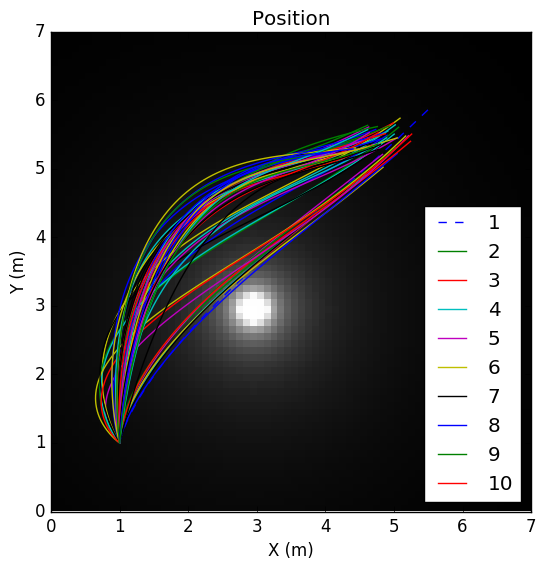

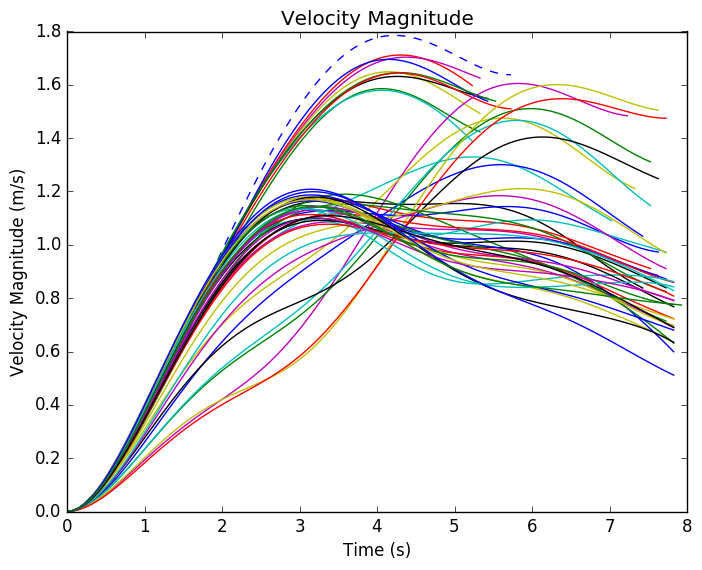

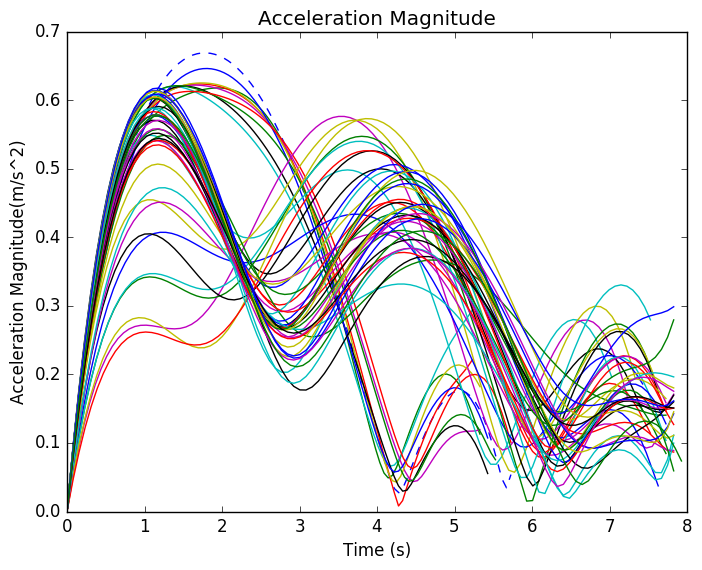

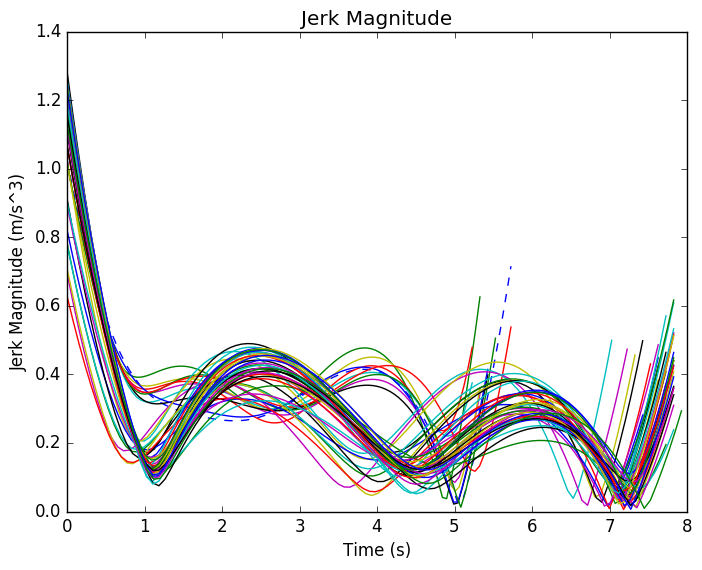

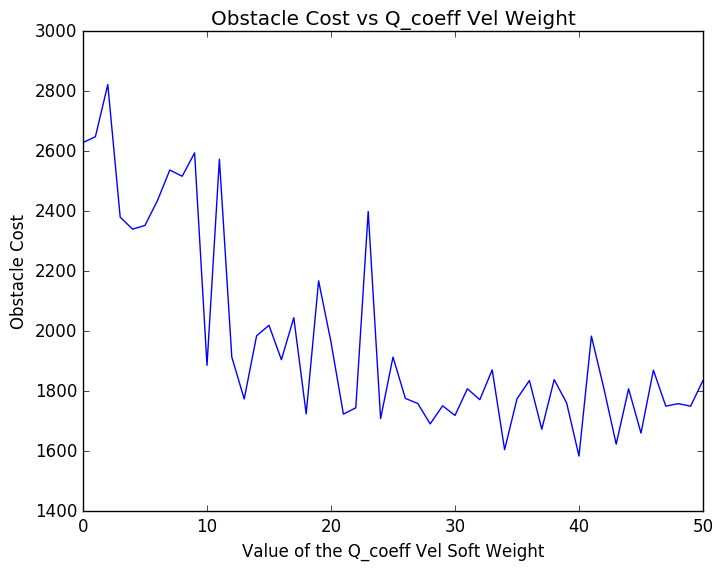

cost after: 4552.48595665241


PyObject <matplotlib.image.AxesImage object at 0x0000000058A6B978>

  likely near C:\Users\tmurphy10\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\tmurphy10\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\tmurphy10\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\tmurphy10\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\tmurphy10\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\tmurphy10\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\tmurphy10\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\tmurphy10\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\tmurphy10\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\tmurphy10\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\tmurphy10\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\tmurphy10\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\tmurphy10\.julia\v0.5\IJulia\src\kernel.jl:31
in show at C:\Users\tmurphy10\.julia\v0.5\PyCall\src\PyCall.jl
  likely near C:\Users\tmurphy10\.julia\

In [270]:
#A test to test a series of values for one parameter
#Initialize seedForRandomness
seedForRandomness = 1;
first = true
plotter = [];
range = 0:1:50
for i =range
    println("Currently at value: ", i)
    #Set Parameter to change
    tuningI.q_coeff[2] = i;
    #Run Planner
    solution = runPathPlanner(tuningI, 
                    problem)
    #Plots
    if(first)
        debugPlotDash(solution, problem, tuningI)
        first = false;
    else
        debugPlot(solution, problem, tuningI)
    end
    plotter = [plotter;tuningI.obstacleWeight*sum(problem.costmap[solution.cells])]
end
figure(5)
plot(range, plotter)
title("Obstacle Cost vs Q_coeff Vel Weight")
xlabel("Value of the Q_coeff Vel Soft Weight")
ylabel("Obstacle Cost")
#plot obstacle
if(!solvHelp.PoutOfBounds)
    figure(1)
    legend(["1", "2", "3", "4", "5", "6", "7","8", "9", "10"], loc = "Best")
    imshow( flipCostmap(problem.costmap),
            cmap = "gray", 
            interpolation="none",
            extent=[0,problem.grid_extent,0,problem.grid_extent])
end

In [ ]:
#Do the lotus test
lotusTest(  5.0,       # initial_distance::Float64, 
            tuningI,   # tuning::TuningParams, 
            2,         # number2Rotate::Int64,
            2.0,       # distanceChange::Float64, 
            1,         # figureNum::Int64)
            problem)   # pathProb::PathProblem

In [ ]:
#Easy Bump Test
easyAvoidBumpTest(  tuningI,# bumpTuning::TuningParams, 
                    problem,# pathProblem::PathProblem, 
                    5000,   # bumpSize::Int64)
                    2,      # figNum::Int64 = 1
                    7.0)    # bumpYLoc::Float64 default is 5.0

In [ ]:
#Doorway Test
#TODO: make params more understandable/consistent with user expectations
#TODO: Add input validation to this test
doorwayTest(tuningI,#wallTuning::TuningParams, 
            problem,#pathProblem::PathProblem, 
            30,     #wallSize::Int64, 
            3,      #figNum::Int64, 
            7.0,    #doorYLoc::Float64, 
            10.0,   #doorWidth::Float64)
            true,   #wallBehindDoor::Bool = false, 
            1.5)    #wallDistance::Float64 = 2.0

In [ ]:
#Hallway Test
#TODO: Add input validation to this test
hallwayTest(tuningI,#hallTuning::TuningParams, 
            problem,#pathProblem::PathProblem, 
            35,     #wallSize::Int64, 
            4)      #figNum::Int64)

In [ ]:
#Random Tuning/Problem Variation Test
#Descritption - the tuning parameters will be varied through a range of values for a constant path problem. Only
# one thing changes
#Requires heavy user input
#This is the Skeleton of the process and a specific variable should be used
#Set bottom value
#Set top value
#Create range between those values
#Loop through the range 
#Set the current value to its appropriate spot in the object
#Run the planner
#Plot
#End Loop

In [ ]:
#Random Ros Bag Test
#Description - read in a ros bag's costmap and path for that costmap
#Inputs
# rosbag
#Expected Outcomes - a plot 

#Pseudo code since I do not know how to do this in Julia yet
#Read in rosbag
#Record a coinciding costmap and global path
#Translate to odom frame
#Pick local goals
#Start timer
#Run path planner
#If unsuccessful choose a different goal until out of goals or successful
#End timer
#Print time
#Plot planned path over the costmap

The current seed: 9
Hit Object
Hit and Obstacle; Trying a random restart 1
Broke limits; Trying random restart 1
cost before: 13184.467657349798
cost after: 10476.379459346195
Hit and Obstacle; Trying a random restart 2
Broke limits; Trying random restart 2
cost before: 17676.773006828276
cost after: 10348.57883944357
Hit and Obstacle; Trying a random restart 3
Broke limits; Trying random restart 3
cost before: 15275.460362701308
cost after: 10877.409297011194
Hit and Obstacle; Trying a random restart 4
Broke limits; Trying random restart 4
cost before: 10513.535621492145
cost after: 10833.71160653538
Hit and Obstacle; Trying a random restart 5
Broke limits; Trying random restart 5
cost before: 10779.543757941272
cost after: 9479.242926853574
Hit and Obstacle; Trying a random restart 6
Broke limits; Trying random restart 6
cost before: 11071.070137203173
cost after: 11256.808942583644
Broke limits; Trying random restart 7
cost before: 11798.08894189911
cost after: 9717.824340927777
Bro

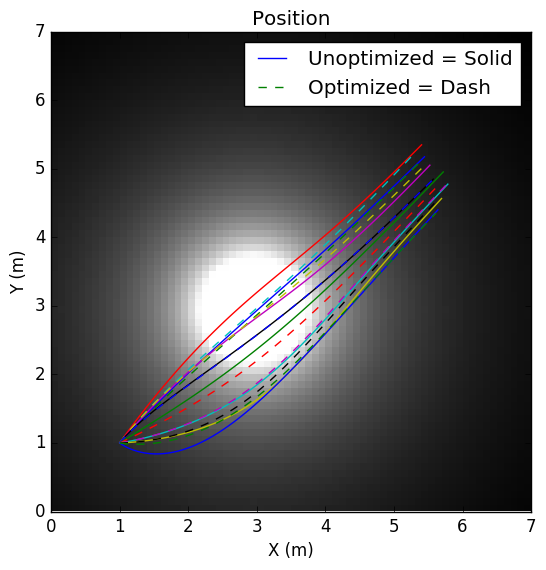

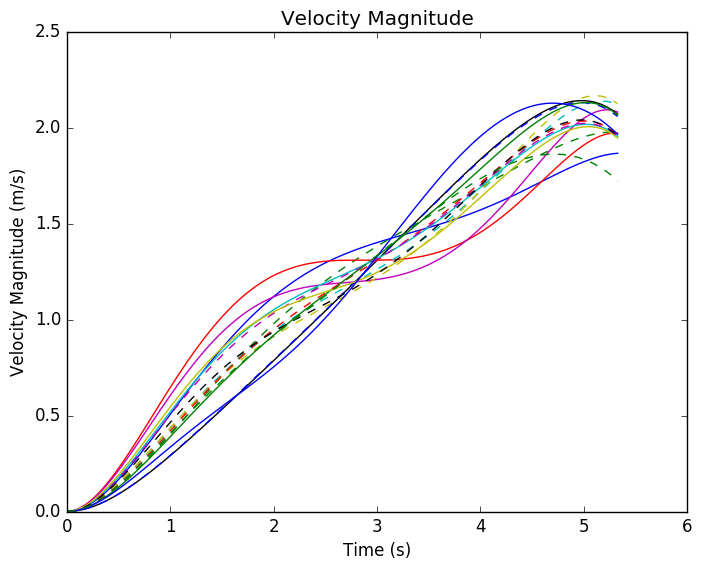

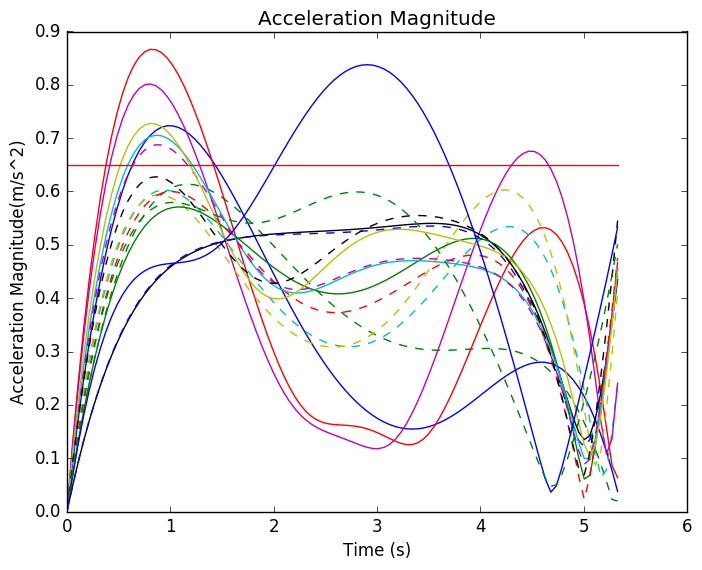

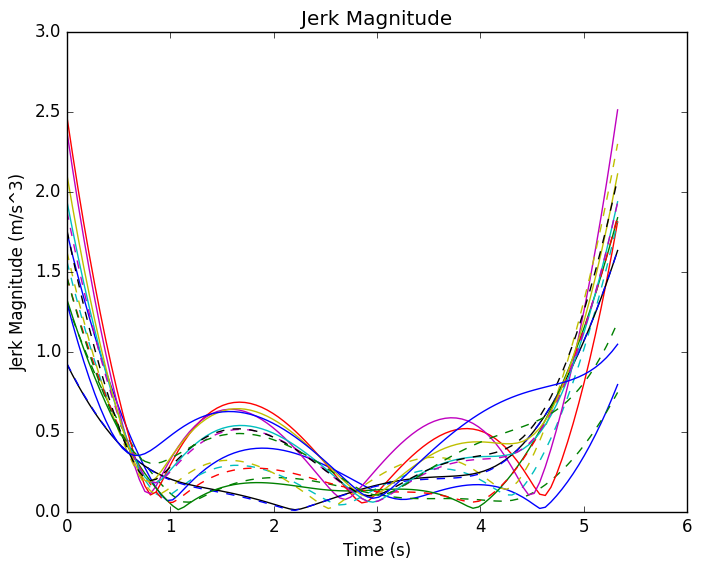

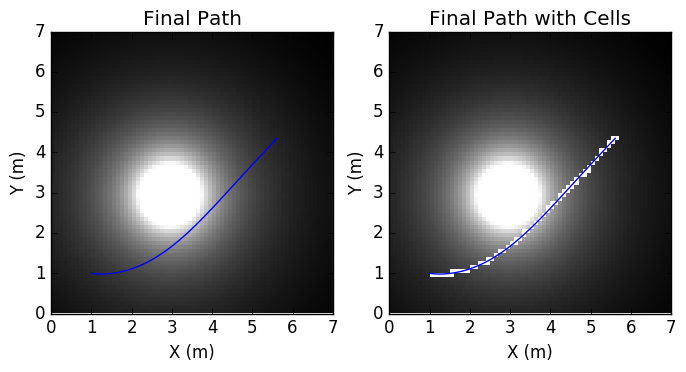

cost after: 9108.64574619385


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000003E45F5C0>

In [277]:
#Code For the Main Function

#Create fatal obstacle constant
FATAL_OBJECT = 255;

#set up seed for randomness
seedForRandomness =9;
println("The current seed: ", seedForRandomness)
srand(seedForRandomness);

#Initialize solver and solution
solution = PathSol( 0.0,     # totTime::Float64 
                    [0.0]'', # coeffs::Array{Float64,2}  
                    [1],     # cells::Array{Int64,1}  
                    0.0)     # cost::Float64         
solvHelp = PolyPathSolver(  [0.0]'', #PA_inv::Array{Float64,2}           
                            [0.0]'', #    PQ::Array{Float64,2}              
                            [0.0]'', #    PoptimizeMatrix::Array{Float64,2}  
                            true,    #    PoutOfBounds::Bool                 
                            true,    #    PunVerified::Bool                
                            10,      #    counterRestart::Int64             
                            100);    #    counterVerified::Int64    
#Create a costmap
problem.costmap = createCostMap(4,problem);
problem.Pgrid_elementNum = round(Int64,ceil(problem.grid_extent/problem.grid_resolution));

#If dijkstras Create a normalized direction vector
if(problem.DijkstraNotFMT)
    addDirectedSpeed!(problem, tuningI.max_vel);
end

#Construct the constraint vectors, orders, and timeIndex given start, end, dof and soft constraint vectors
#TODO: make void functions with pointers to avoid so much copying
problem = constructConstr(problem)

#initialize time to a reasonable time so polynomial doesn't explode, a reasonable time will be
solution.totTime = initializeTime(problem, tuningI);

#while loop until verified 
while(solvHelp.PunVerified)
    #Increment time on every loop
    solution.totTime += tuningI.timeIncrease;
    
    #Form A_inv
    solvHelp.PA_inv = constr_Ainv(  problem.PconstraintOrders,
                                    problem.PtimeIndex*solution.totTime, #Multiply by the total time for proper function
                                    problem.Pdegree);

    #Add/subtract stuff to/from q_coeff if not equal to the degree
    tuningI.q_coeff = checkQcoeffs(tuningI.q_coeff, problem.Pdegree)

    #Form Q
    solvHelp.PQ = form_Q(tuningI.q_coeff,solution.totTime);

    #Form OptimizeMat
    solvHelp.PoptimizeMatrix = form_OptimizeMat(problem,tuningI,solvHelp);

    #update the free constraints as necessary
    problem.PconstrFree = updateFreeConstr(problem,solvHelp);
    #problem.PconstrFree = createRandomRestart(problem, tuningI);

    #solve for the polynomial coefficients
    solution.coeffs = solvePolysInitially(problem,solvHelp);

    #Check in bounds and collect the cells
    solution.cells, solvHelp.PoutOfBounds = occupancyCellChecker(solution, problem, tuningI);

    #Break if out of bounds and display an error
    if(solvHelp.PoutOfBounds)
        println("Plan Fail: Went out of Bounds")
        break;
    end

    #Verify good path
    errorVals, errorTypes = simpleVerifyFeas(solution, tuningI)

    #If not verified increment time
    if(!isempty(errorVals))
        #Repeat loop over
        continue; 
    end
    #If verified do not say verified  until next verify
    
    #Check if not hitting an obstacle since if it is it will not succeed.
    if(any(problem.costmap[solution.cells].>=FATAL_OBJECT))
        #Break and go to random restarts
        println("Hit Object")
        break;
    end
    
    #Plotting that can be removed later plots initial solution as a solid line
    debugPlot(solution, problem, tuningI)
    
    #Create a holder for the free constr
    df = form_df(problem);
    
    #Calculate the initial cost
    solution.cost = costFunc(df, solution, problem, solvHelp, tuningI)
    
    #optimize free constraints with limits built in using the COST function
    solution, problem.PconstrFree, solvHelp.PoutOfBounds = 
        selfGradientDescent(solution,problem,tuningI,solvHelp);
    
    #Plotting that can be removed later plots optimized solution as a dash line
    debugPlotDash(solution, problem, tuningI)
    
    #Verify good path
    errorVals, errorTypes = simpleVerifyFeas(solution, tuningI)

    #If not verified increment time
    if(!isempty(errorVals))
        #Repeat loop over
        continue; 
    end
    solvHelp.PunVerified = false
    #If verified do not say verified  until next verify
end

#Save temporary free constraints
freeConstrFirst = problem.PconstrFree;
#Start random restarts if hitting an obstacle
restartCounter = 0;
while((any(problem.costmap[solution.cells] .>= FATAL_OBJECT) || solvHelp.PunVerified) && 
    restartCounter < tuningI.numberOfRandomRestarts)
    #Print message about hitting an obstacle and random restarting
    if(any(problem.costmap[solution.cells] .>= FATAL_OBJECT))
        println("Hit and Obstacle; Trying a random restart $(restartCounter+1)")
    end
    if(solvHelp.PunVerified)
        println("Broke limits; Trying random restart $(restartCounter+1)")
    end
    #Create random start
    problem.PconstrFree = createRandomRestart(problem, tuningI);
    #solve for the polynomial coefficients
    solution.coeffs = solvePolysInitially(problem,solvHelp);
    
    #Check in bounds and collect the cells
    solution.cells, solvHelp.PoutOfBounds = occupancyCellChecker(solution, problem, tuningI);

    #Break if out of bounds and display an error
    if(solvHelp.PoutOfBounds)
        println("Plan Fail: Went out of Bounds In the Initial Optimization")
        #break;
    end
    
    #optimize -Note there is no verification step anymore so no more increasing time
    #Create a holder for the free constr
    df = form_df(problem);
    
    #Calculate the initial cost
    solution.cost = costFunc(df, solution, problem, solvHelp, tuningI)
    debugPlot(solution, problem, tuningI)
    #1)OPTIMIZE free constraints with limits built in; 2)COST function
    println("cost before: ", costFunc(df, solution, problem, solvHelp, tuningI))
    
    #optimize free constraints with limits built in using the COST function
    solution, problem.PconstrFree, solvHelp.PoutOfBounds = 
        selfGradientDescent(solution,problem,tuningI,solvHelp);
    df = form_df(problem);
    println("cost after: ", costFunc(df, solution, problem, solvHelp, tuningI))
    debugPlotDash(solution, problem, tuningI)
    
    #If no collision verify
    if(!(any(problem.costmap[solution.cells] .>= 255)))
        #Verify good path
        errorVals, errorTypes = simpleVerifyFeas(solution, tuningI)
        #Check if verified, if not verified make it so that the loop happens again
        if(isempty(errorVals))
            #Repeat loop over
            solvHelp.PunVerified = false;
        else
            #Would repeat loop over if other things are tur
            solvHelp.PunVerified = true;
        end
    end
    problem.PconstrFree = freeConstrFirst;
    restartCounter += 1; 
end

#Print if made failed to plan a path around obstacle
if(restartCounter >= tuningI.numberOfRandomRestarts)
    println("Path Planning Failed even with Restarts: Sad Face :(")
end


if(!solvHelp.PoutOfBounds)
    figure(1)
    imshow( flipCostmap(problem.costmap),
            cmap = "gray", 
            interpolation="none",
            extent=[0,problem.grid_extent,0,problem.grid_extent])
    #PLOT optimized function?
else
    #Plotting that will occur if path goes out of bounds
    debugPlot(solution, problem, tuningI)
end

#####DEBUGGING With Labels Home Dog!###############
legend(["Unoptimized = Solid", "Optimized = Dash"], loc = "Best")
pathCellPlot(problem, solution, tuningI)
figure(3)
times = linspace(0,solution.totTime, tuningI.timeRes)
plot(times, ones(size(times))*tuningI.max_accel)
###########################

#Return path

In [ ]:
Pkg.add("Clp")

In [ ]:
#Create the optimization function for use in JuMP
#Desription: 
#Assumptions
#Inputs
# initSol - a PolySol type of the initial solution to optimize from
# theTuning - a TuningParams type for determing constraints and weights:
#   numericVelWeight::Float64          # The weight for the cost for not being at max_vel at any time
#   obstacleWeight::Float64            # The weight for the cost of going through a cell in the costmap
#   derivativeWeight::Float64          # The weight for the combined derivative cost term
#   precision::Float64                 # The tolerance to solve within
#   iterations::Int64                  # Number of times to do optimization step
#   aggressParam::Float64              # Closer to 0 means check every point on the path, infinity => check no points
#   max_vel::Float64                   # Max total velocity the path is restricted to
#   max_accel::Float64                 # Max total acceleration the path is restricted to
#   max_jerk::Float64                  # Max total jerk the path is restricted to
#   timeWeight::Float64                # Weight applied to time
#   timeRes::Int64                     # How many points for determining limits and constraints
# solvStuff - the PolyPathSolver with the following parameters to help create the objective function:
#   PA_inv::Array{Float64,2}           # The matrix that transforms constraints to coefficients A_inv*d=p
#   PQ::Array{Float64,2}               # Matrix representation of the q_coeff weights
#   PoptimizeMatrix::Array{Float64,2}  # Gives the optimal free/soft constraints given fixed constraints
#   PoutOfBounds::Bool                 # True if path ever goes outside the costmap scope
# problem - the PathProblem type that has the initial conditions and dimension flag:
#   PconstrFixed::Array{Float64,2}   # All fixed constraints
#   PconstrFree::Array{Float64,2}    # A holder for all soft and free contraints
#   isDim3::Bool                     # The flag for 3D; 2 will be added later so the dimension is only 2 or 3
#   costmap::Array{Int8,3}           # The 3D voxel occupancy grid
#   grid_extent::Float64             # The extent of the cost map in meters
#   grid_resolution::Float64         # The resolution of the cost map in meters
#   Pgrid_elementNum::Int64          # The max index of the grid of the cost map
# velMatrix - a matrix that turns a poly coeff vector into the poly coeff vector of the poly's 1st derivative
# accMatrix - a matrix that turns a poly coeff vector into the poly coeff vector of the poly's 2nd derivative
# jerkMatrix - a matrix that turns a poly coeff vector into the poly coeff vector of the poly's 3rd derivative
#Outputs
# solvSol - the optimized solution in the form the minimizing free constraints
# successful - a boolean that communicates success if true failure otherwise
function optimizeJump(initSol,theTuning,solvStuff,prob,velMatrix,accMatrix,jerkMatrix)
    ##Create model
    #Call the Model function
    m = Model()
    #Create a dim variable to know the dimension
    dim = prob.isDim3+2;
    ##Create variables
    #Create the free constraint variable starting
    #TODO: find a way to remove the length call (maybe add to one of the objects holders)
    #find the length of the free variables to determine how many there are to change and add one for time
    lenFree = size(prob.PconstrFree,2);
    #       Model,      Variable name,                Actual initial values of the constraints
    @variable(  m, free[1:dim, 1:lenFree])#, start = [prob.PconstrFree]) 
    for i in 1:dim
        for j in 1:lenFree
            setvalue(free[i,j], prob.PconstrFree[i,j]);
        end
    end
    #Create fixed variable for the fixed constraints
    @variable( m, fixed[d = 1:dim,f = 1:prob.Pdegree-lenFree,] == prob.PconstrFixed[d,f])
    if(prob.isDim3)
        #Create fixed variable for the costmap
        @variable(m, costmap[x = 1:prob.Pgrid_elementNum,
                            y = 1:prob.Pgrid_elementNum,
                            z = 1:prob.Pgrid_elementNum] == prob.costmap[x,y,z])
    else
        #Create fixed variable for the costmap
        @variable(m, costmap[x = 1:prob.Pgrid_elementNum,
                            y = 1:prob.Pgrid_elementNum] == prob.costmap[x,y,1])
    end
    
    #TODO: see if for loops work here: not sure it would since it is now a symbol 
    #TODO: think of better way of dealing with the ability to have 2 or 3 dimensions
    #Create a d matrix to hold the respective d vectors as rows and the p's
    dVecs = [fixed[1,:]' free[1,:]'];
    p =  (solvStuff.PA_inv * dVecs');
    for i = 2:(prob.isDim3+2)
        dVecs = [dVecs; fixed[i,:]' free[i,:]'];
        p = [p (solvStuff.PA_inv * dVecs[i,:])];
    end
    #Create the expression for the derivatives
    if(prob.isDim3)
        derivExpr = (p[:,1])' *          #p^T
                        solvStuff.PQ *   #Q
                        (p[:,1]) +       #p -> x coefficients cost
                     (p[:,2])' *         #p^T
                        solvStuff.PQ *   #Q
                        (p[:,2]) +       #p -> y coefficients cost
                     (p[:,3])' *         #p^T
                        solvStuff.PQ *   #Q
                        (p[:,3]);        #p -> z coefficients cost
    else
        derivExpr = (p[:,1])' *          #p^T
                        solvStuff.PQ *   #Q
                        (p[:,1]) +       #p -> x coefficients cost
                     (p[:,2])' *         #p^T
                        solvStuff.PQ *   #Q
                        (p[:,2]);        #p -> y coefficients cost
    end


    ##Create Constraints
    #Create a time vector to check the constraints and costs on
    checkTimes = linspace(0.0, initSol.totTime, theTuning.timeRes);
    mapExpr = 0;
    for t in checkTimes
        #Create a T row vector
        T = [1.0]
        for i = 1:(prob.Pdegree-1)
            T = [T t^i];
        end
        #Create the position constraints: This will make checking out of bounds obsolete most of time
        for i = 1:dim
            @constraint(m, T*p[:,i] .<= prob.grid_extent) #upper position bound
            @constraint(m, T*p[:,i] .>= 0) #lower position bounds
        end
        #initialize mapExpr
        
        if(prob.isDim3)
            #Create the velocity constraints: This will make verification steps obsolete
            @constraint(m, norm(T*velMatrix*[p[:,1] p[:,2] p[:,3]]) <= theTuning.max_vel)
            #Create the acceleration constraints: This will make verification steps obsolete
            @constraint(m, norm(T*accMatrix*[p[:,1] p[:,2] p[:,3]]) <= theTuning.max_accel)
            #Create the jerk constraints: This will make verification steps obsolete
            @constraint(m, norm(T*jerkMatrix*[p[:,1] p[:,2] p[:,3]]) <= theTuning.max_jerk)
            #Create the costmap expression
            mapExpr += costmap[[T*p[:,1],T*p[:,2],T*p[:,3]]];
        else
            #Create the velocity constraints: This will make verification steps obsolete
            @constraint(m, norm(T*velMatrix*[p[:,1] p[:,2]]) <= theTuning.max_vel)
            #Create the acceleration constraints: This will make verification steps obsolete
            @constraint(m, norm(T*accMatrix*[p[:,1] p[:,2]]) <= theTuning.max_accel)
            #Create the jerk constraints: This will make verification steps obsolete
            @constraint(m, norm(T*jerkMatrix*[p[:,1] p[:,2]]) <= theTuning.max_jerk)
            #Create the costmap expression
            #mapExpr += costmap[[T*p[:,1],T*p[:,2],1]];
        end
    end
    #Multply costmap by weight
    #mapExpr *= theTuning.ObstacleWeight;
    ##Create nonlinear objective function from all the expressions
    #This requires auxillary variables in order to be used
    @variable(m, aux)
    @constraint(m, aux == derivExpr[1])
    @objective(m, Min, aux)
    ##Solve
    #Solve for the given amount of iterations
    solve(m)
    ##Update the appropriate variables
    #Recreate a d matrix and the p's
    for i = 1:dim
        dVecs[i,:] = [prob.PconstrFixed[i,:]' free[i,:]];
        p[:,i] = (solvStuff.PA_inv * dVecs[i,:]');
    end
    return getvalue(free);
end


In [ ]:
using JuMP
m = Model()
@variable(m, x, start = 0.0)
@variable(m, y, start = 0.0)

@NLobjective(m, Min, (1-x)^2 + 100(y-x^2)^2)

solve(m)
println("x = ", getvalue(x), " y = ", getvalue(y))

# adding a (linear) constraint
@constraint(m, x + y == 10)
solve(m)
println("x = ", getvalue(x), " y = ", getvalue(y))

In [ ]:
#Control
#Construct the all the containers
tuningI = TuningParams([0;1;0;1;0],    # q_coeff::Vector{Int64}
                       [500.0;500.0],  # softConstrWeights::Vector{Float64}
                        0.1,           # numericVelWeight::Float64       
                        0.01,          # obstacleWeight::Float64    
                        0.1,           # derivativeWeight::Float64     
                        1e-8,          # precision::Float64              
                        20,            # iterations::Int64      
                        0.01,          # timeStep::Float64     
                        2.0,           # timeStart::Float64    
                        0.7,           # aggressParam:Float64        
                        0.1,           # timeIncrease::Float64            
                        2.0,           # max_vel::Float64           
                        0.65,          # max_accel::Float64        
                        10.0,          # max_jerk::Float64             
                        10,            # numberOfRandomRestarts::Int64   
                        10,            # timeWeight::Float64    
                        100);          #timeRes::Int64   
problem = PathProblem( [1.0 0.0 0.0;        # x
                        1.0 0.0 0.0;        # y
                        1.0 0.0 0.0],       # z  #start_config::Array{Float64,2}   
                       [5.0;                # x
                        6.0;                # y
                        7.0]'',             # z #end_config::Array{Float64,2}      
[true], # soft_constr::Vector{Bool}     
                        true,               # DijkstraNotFMT::Bool          
                        zeros(0,2),         # PconstrFixed::Array{Float64,2}  
    #TODO: actually create a constructor function to construct the constr* and time index vectors
                        zeros(0,2),         # PconstrFree::Array{Float64,2}       
                        [0;0;0;1;1;1],      # PtimeIndex::Vector{Int64}       
                        [0;1;2;0;1;2],      # PconstraintOrders::Vector{Int64}
                        zeros(0,2),         # PconstraintSoft::Array{Float64,2}    
                        false,              # isDim3::Bool                  
                        1,                  # dof::{Int64}                   
                        zeros(0,0,1),       # costmap::Array{Int8,3}         
                        10.0,               # grid_extent::Float64  
                        0.1,                # grid_resolution::Float64
                        0,                  # Pgrid_elementNum::Int64 
                        0)                  # Pdegree::Int64 
solution = PathSol( 0.0,     # totTime::Float64 
                    [0.0]'', # coeffs::Array{Float64,2}  
                    [1],     # cells::Array{Int64,1}  
                    0.0)     # cost::Float64         
solvHelp = PolyPathSolver(  [0.0]'', #PA_inv::Array{Float64,2}           
                            [0.0]'', #    PQ::Array{Float64,2}              
                            [0.0]'', #    PoptimizeMatrix::Array{Float64,2}  
                            false,   #    PoutOfBounds::Bool                 
                            false,   #    PunVerified::Bool                
                            10,      #    counterRestart::Int64             
                            100);    #    counterVerified::Int64         
#Initialize solver and solution
solution = PathSol( 0.0,     # totTime::Float64 
                    [0.0]'', # coeffs::Array{Float64,2}  
                    [1],     # cells::Array{Int64,1}  
                    0.0)     # cost::Float64         
solvHelp = PolyPathSolver(  [0.0]'', #PA_inv::Array{Float64,2}           
                            [0.0]'', #    PQ::Array{Float64,2}              
                            [0.0]'', #    PoptimizeMatrix::Array{Float64,2}  
                            true,    #    PoutOfBounds::Bool                 
                            true,    #    PunVerified::Bool                
                            10,      #    counterRestart::Int64             
                            100);    #    counterVerified::Int64    
#Create a costmap
problem.costmap = createCostMap(0,problem);

In [160]:

#Calculate solution
#Check occupancy and in bounds
#if out of bound leave early
#Create new cost
#find change in cost
#Record change in a vector and direction if in the correct way
#end for loop
#Normalize the gradient vector
#Step in that direction
#Check if step is too small or if change is too small and break if within precision
#If step was a decrease step keep that and increase step size
#If step was an increase revert the step and half the step size
#end while?
#Check if passed max itereations

LoadError: LoadError: UndefVarError: MAX_FLOAT not defined
while loading In[160], in expression starting on line 3